In [35]:
%%writefile README.md
# Dollar Cost Averaging - Custom DCA (buy the dip)


# Overview
Dollar Cost Averaging - DCA: Dividing a sum of money to invest periodically, reducing the impact of volatility on the purchase price. DCA is the commonly accepted risk mitigating way to invest in crypto. But can we do better?

**Buy the dip** - I'm sure you've heard it before but it's much easier said than done. The indicators in this repo are provided to help buy the dip algorithmically: Weighting the buy amount per order to invest more when it's likely crypto is in a dip and less when it is not.

This repo lets you run and backtest DCA strategies for crypto to minimise risk and maximise profits, allowing for user customisation with respect to frequency of purchasing, use of indicators and aggression or weighting

### Setup instructions

1. To get started you will need an exchange account from Binance/FTX/Kraken (Fee reducing referral links below):

    - [x] [binance.com](https://accounts.binance.com/en/register?ref=CP1DAOWU)
    - [x] [ftx.com](https://ftx.com/#a=33799830)
    - [x] [kraken.com](https://r.kraken.com/KeJqje)


2. Load up your spot wallet with USD or USDT or whatever currency you want to use to buy crypto 
<br></br>
3. Create API keys with 'trading' permissions enabled
<br></br>
4. Put your API keys in a json file called `keys.json` one directory above the repo (Only the exchange keys used to trade need to be included)

```
{
    "binance_keys":{
        "api_key":"XXXXXXXXXXXXXXXXXXXX",
        "secret_key":"XXXXXXXXXXXXXXXXXXXX"
    },
    "ftx_keys":{
        "api_key":"XXXXXXXXXXXXXXXXXXXX",
        "secret_key":"XXXXXXXXXXXXXXXXXXXX"
    },
    "kraken_keys":{
        "api_key":"XXXXXXXXXXXXXXXXXXXX",
        "secret_key":"XXXXXXXXXXXXXXXXXXXX"
    }
}
```

5. Install the required python packages using `pip install -r requirements.txt` from the root directory
<br></br>
6. Run `python dca.py` to start or `python dca.py -s` to start in simulation mode (places fake trades)
<br></br>
7. Follow the instructions in the command prompt to set up alternatively use the config.json file (Work in progress) 

Places (spot) market buy orders on the exchange at the current price, it then sleeps until the next buy interval. It will save progress so it doesn't have to be continuously run but I would reccomend running this perpetually (on a linux based microcomputer like a Rasberry Pi). Different DCA strategies will be put in as we go!

Strategies tested and planning to be tested:
- [x] According to the Crypto Fear and Greed Index https://alternative.me/crypto/fear-and-greed-index (Buys more when fear is higher, buys less when greed is higher)
- [ ] RSI based DCA
- [ ] Volatility Based DCA


## Fear and Greed
![fear_greed](fg_btc.png)

The fear and greed strategy chart shows 100 - fear and greed index (red) and bitcoin price (blue). When fear is high (red line close to 100) invest more and when greed is high (red line close to 0) invest less. By doing this we can invest according to this weighting to increase the amount of BTC held over a long period of time compared to regular DCA.

Current fear and greed:

<img src="https://alternative.me/crypto/fear-and-greed-index.png" alt="Latest Crypto Fear & Greed Index" width="350" height="300" class="center"/>

### Updates
September 13th
- Updated analysis notebook with charts of historical fear and greed performance
- Printing of summary statistics of dca avg buy price and total spent

September 12th
- Allows for stopping, saving and restarting allowing the user to choose to buy at the current price or skipping instead

August 27th
- FTX Set up and more intuitive UI. Also more backtesting in the analysis notebook

August 12th:
- Fear and greed DCA handling for buy amounts lower than the minimum buy amount for each coin

August 8th:
- Basic DCA works for all cryptos on Binance, needs to be run permanently


Overwriting README.md


In [51]:
!git add -A && git commit -m "updated fear and greed chart" && git push

[main cb74222] updated fear and greed chart
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite fg_btc.png (98%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 12 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 55.79 KiB | 18.60 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
remote: This repository moved. Please use the new location:
remote:   https://github.com/jaimindp/dollar_cost_average_dip_buying.git
To https://github.com/jaimindp/dollar_cost_average_crypto.git
   6b3c303..cb74222  main -> main


# Notebook to test out different DCA strategies

Ways to optimise getting into crypto minimising risk and maximising profit

- [x] Regular Dollar Cost averaging
- [x] Weighting crypto fear and greed index
- [ ] Exponentially decreasing with price increase
- [ ] Proportional to RSI

In [37]:
import json
import traceback
import ccxt
from datetime import datetime, timedelta
import time
import pytz
from datetime import timedelta
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from itertools import accumulate
import matplotlib
import pandas as pd
import numpy as np
import requests 
import ast

## Price Data

In [38]:
# Using binance to get data for now
exchange = ccxt.binance({})

In [39]:
# Get tickers for coins you want to buy
btc = 'BTC/USDT'
eth = 'ETH/USDT'
# link = 'LINK/USDT'
# sol = 'SOL/USDT'
# ada = 'ADA/USDT'
# dot = 'DOT/USDT'
# luna = 'LUNA/USDT'
# uni = 'UNI/USDT'
# sushi = 'SUSHI/USDT'
# ftt = 'FTT/USDT'

all_tickers = {'btc':{'ticker':btc}, 
               'eth':{'ticker':eth}, 
#               'link':{'ticker':link}, 
#                'sol':{'ticker':sol}, 
#                'ada':{'ticker':ada}, 
#                'dot':{'ticker':dot}, 
#               'luna':{'ticker':luna}, 
#                'uni':{'ticker':uni}, 
#              'sushi':{'ticker':sushi}, 
#                'ftt':{'ticker':ftt}, 
              }

# Get historical data
start_date = datetime.now() - timedelta(days=365*4)
start_timestamp = round(start_date.timestamp() * 1000)

In [40]:
# Functions to help with the data
# Convert data from binance to pandas df
def convert_pandas(data):
    header = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df = pd.DataFrame(data, columns=header).set_index('timestamp')
    df.index = df.index.map(lambda x : datetime.fromtimestamp(round(x/1000)))
    return df

# Convert a datetime to the local timezone
def convert_timezone(dt,from_tz=pytz.timezone('UTC'),to_tz=pytz.timezone('Europe/London')):
    utc_dt = dt.replace(tzinfo=from_tz)
    return utc_dt.astimezone(to_tz)

# Get the data from a ticker since it's earliest interval to present
def fetch_data(ticker, since, until=datetime.now(), interval='1d'):
    
    week_data = exchange.fetch_ohlcv(ticker,'1w')
    since = max(since,week_data[0][0])
    data = exchange.fetch_ohlcv(ticker, interval, since=since)
    
    while data and datetime.fromtimestamp(data[-1][0]/1000) < until - timedelta(days=1):
        data += exchange.fetch_ohlcv(ticker, interval, since=data[-1][0])[1:]
        
    return data  

In [41]:
# Fetch the ticker data, convert it to pandas and store DFs in d dictionary
for k,v in all_tickers.items():
    all_tickers[k]['data'] = fetch_data(v['ticker'], start_timestamp)    
    all_tickers[k]['df'] = convert_pandas(all_tickers[k]['data'])

In [42]:
# Get all the data in one DataFrame
data_df = pd.DataFrame()
for coin in all_tickers:
    temp_df = all_tickers[coin]['df']
    temp_df['ticker'] = coin
    data_df = data_df.append(temp_df)

In [43]:
data_df

,open,high,low,close,volume,ticker
timestamp,,,,,,
2017-10-21 01:00:00,6013.72,6171.00,5850.03,6024.97,1664.307693,btc
2017-10-22 01:00:00,6003.27,6060.00,5720.03,5950.02,1362.092216,btc
2017-10-23 01:00:00,5975.00,6080.00,5621.03,5915.93,1812.557715,btc
2017-10-24 01:00:00,5909.47,5925.00,5450.00,5477.03,2580.418767,btc
2017-10-25 01:00:00,5506.92,5704.96,5286.98,5689.99,2282.813205,btc
...,...,...,...,...,...,...
2021-10-15 01:00:00,3790.82,3907.77,3734.10,3868.99,504321.732000,eth
2021-10-16 01:00:00,3868.38,3971.00,3803.56,3829.96,373727.854900,eth
2021-10-17 01:00:00,3829.96,3919.19,3640.00,3846.85,368898.983100,eth


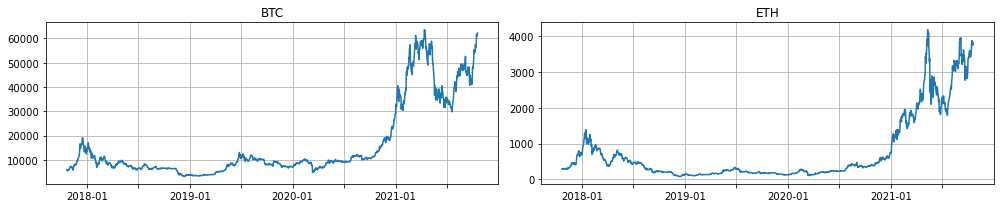

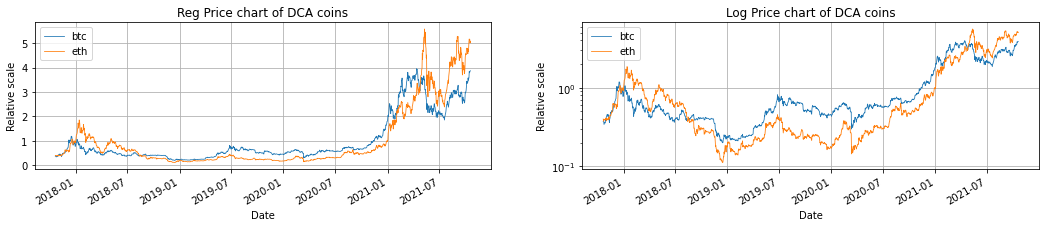

In [44]:
# Plot the charts for the coins to dca

fig, ax = plt.subplots(len(all_tickers)//2,2, figsize=(14,3))
for i, ticker in enumerate(all_tickers):
    row, col = i//2, i%2
    ax = ax[row,:] if len(all_tickers) > 2 else ax[:]
    ax[col].plot(data_df[data_df.ticker == ticker].close)
    ax[col].set_title(ticker.upper())
    ax[ col].grid()
    
    every_nth = 2
    for n, label in enumerate(ax[col].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

fig.tight_layout()
plt.show()


# Plotting the price of the coins on the same axis
# Scale the df so we can look at the charts together
scaled_df = data_df
scaled_df['avg'] = data_df.groupby('ticker')['close'].transform('mean')
scaled_df['scaled'] = scaled_df.close / scaled_df.avg

# Plot on same axes
fig, ax = plt.subplots(1,2,figsize=(18,3))

scaled_df.groupby('ticker')['scaled'].plot(legend=True, linewidth=0.8, ax=ax[0])
scaled_df.groupby('ticker')['scaled'].plot(legend=True, logy=True, linewidth=0.8, ax=ax[1])

ax[0].set_title('Reg Price chart of DCA coins')
ax[1].set_title('Log Price chart of DCA coins')
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')
ax[0].set_ylabel('Relative scale')
ax[1].set_ylabel('Relative scale')
plt.show()

## Fear and Greed index

In [45]:
# Pull Fear and Greed daily Data (Returned much quicker on repeat, check and test headers)
endpoint = 'https://api.alternative.me/fng/?limit=3000&format=json&date_format=uk'
fg_data =  requests.get(endpoint).json()

In [46]:
# Individual value for fear and greed
endpoint_individual = 'https://api.alternative.me/fng/?format=json&date_format=uk'
fg_data_individual = requests.get(endpoint_individual).json()
fg_data_individual['data'][0]

{'value': '75',
 'value_classification': 'Greed',
 'timestamp': '19-10-2021',
 'time_until_update': '-1634552824'}

In [47]:
# Convert fear and greed data to df
fg_values = pd.DataFrame()
fg_values['fear_greed'] = [int(x['value']) for x in fg_data['data']]
fg_values.index = [x['timestamp'] for x in fg_data['data']]
fg_values.index = pd.to_datetime(fg_values.index, dayfirst=True)

In [48]:
# Scale fear and greed and BTC price for same axes

scaled_df_date = scaled_df.copy()
scaled_df_date.index = scaled_df_date.index.date
fg_df = scaled_df_date.join(fg_values)
# fg_df = fg_df[(fg_df.index >= fg_df.dropna().index[0])]
print('Mean fear and greed: %.2f' % fg_df.mean().fear_greed)
fg_df

Mean fear and greed: 46.17


,open,high,low,close,volume,ticker,avg,scaled,fear_greed
2017-10-21,6013.72,6171.00,5850.03,6024.97,1664.307693,btc,16079.087801,0.374708,NaN
2017-10-21,304.51,305.34,290.00,298.94,8591.631210,eth,748.055932,0.399623,NaN
2017-10-22,6003.27,6060.00,5720.03,5950.02,1362.092216,btc,16079.087801,0.370047,NaN
2017-10-22,298.99,306.99,290.00,293.79,7173.068930,eth,748.055932,0.392738,NaN
2017-10-23,5975.00,6080.00,5621.03,5915.93,1812.557715,btc,16079.087801,0.367927,NaN
...,...,...,...,...,...,...,...,...,...
2021-10-17,3829.96,3919.19,3640.00,3846.85,368898.983100,eth,748.055932,5.142463,79.0
2021-10-18,61528.32,62695.78,59844.45,62009.84,51798.448440,btc,16079.087801,3.856552,78.0
2021-10-18,3847.00,3893.14,3676.00,3744.96,401819.973400,eth,748.055932,5.006257,78.0
2021-10-19,62005.60,62998.00,61526.62,62198.84,16191.251458,btc,16079.087801,3.868307,75.0


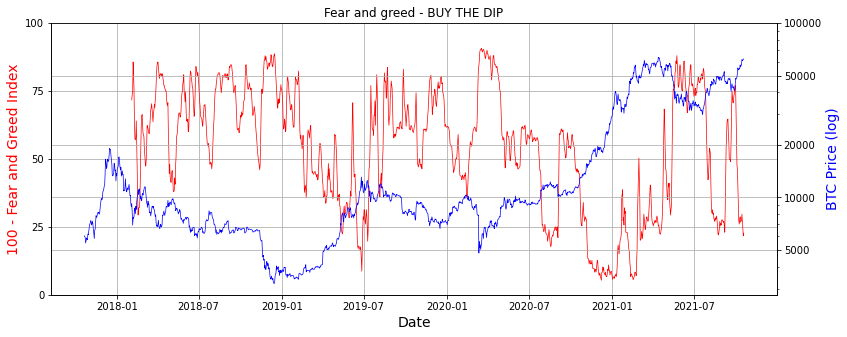

In [49]:
# Plot 100 - fear and greed vs BTC price over time

# Using a rolling mean of 7 to smooth the data
rolling_mean = 3
# rolling_mean = 7
fig,ax = plt.subplots(figsize=(13,5))

ax.plot(fg_df.ffill()[fg_df.ticker=='btc'].index, 100-fg_df.ffill()[fg_df.ticker=='btc'].fear_greed.rolling(window=rolling_mean).mean(), color="red", linewidth=0.7)

ax.set_xlabel("Date",fontsize=14), 
ax.set_yticks([0,25,50,75,100])
ax.set_ylabel("100 - Fear and Greed Index", color="red", fontsize=14)

ax2 = ax.twinx()
ax2.plot(fg_df[fg_df.ticker=='btc'].index, fg_df[fg_df.ticker=='btc'].close, color="blue", linewidth=0.7)
ax2.set_yscale('log')
ax2.set_yticks([5000, 10000, 20000, 50000, 100000])
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylabel("BTC Price (log)", color="blue", fontsize=14)

ax2.grid()
ax.grid()

plt.title('Fear and greed - BUY THE DIP')
plt.savefig('fg_btc.png')
plt.show()

In [50]:
# DCA which gives you the total amount invested over a time period and the average price you would have got
class DCA:
    def __init__(self, total, df, since=datetime.now() - timedelta(days=365*3.3)):
        self.total = total
        self.since=since
        self.df = df
    
    # Run the dca strategy with the parameters entered
    def get_average(self, dollar_amount, freq, ticker, weighting=None):
        ret_df, prices, volumes, dates, spent, break_flag = pd.DataFrame(), [], [], [], 0, False
        
        # Loop over every row
        weight = 1
        for i, row in enumerate(self.df[self.df.index > self.since].iterrows()):
            
            if weighting:
                weight = row[1][weighting]
            
            if spent >= self.total:
                ret_df = ret_df.append(pd.DataFrame([[row[0],row[1].open,weight,0,spent,0,0,sum(volumes)]],
                    columns=['date','price','weight','dollar_spend','dollar_spend_tot','dollar_left','crypto_vol','crypto_tot']))
                
            elif i % freq == 0:
                dates.append(row[0])
                
                # Calculate the last amount to if the total amount to spend has run out
                if spent + dollar_amount * weight >= self.total:
                    
                    leftover_dollar = self.total - spent
                    crypto_vol = leftover_dollar / row[1].open
                    volumes.append(crypto_vol)
                    prices.append(row[1].open)
                    spent += leftover_dollar
                    
                    ret_df = ret_df.append(pd.DataFrame([[row[0],row[1].open,weight,leftover_dollar,spent,0,crypto_vol,sum(volumes)]],
                    columns=['date','price','weight','dollar_spend','dollar_spend_tot','dollar_left','crypto_vol','crypto_tot']))
                    continue
                    
                
                crypto_vol = dollar_amount * weight / row[1].open
                dollar_spend = dollar_amount * weight
                
                volumes.append(crypto_vol)
                prices.append(row[1].open)
                spent += dollar_spend
                
                ret_df = ret_df.append(pd.DataFrame([[row[0],row[1].open,weight,dollar_spend,spent,self.total-spent,crypto_vol,sum(volumes)]],
                    columns=['date','price','weight','dollar_spend','dollar_spend_tot','dollar_left','crypto_vol','crypto_tot']))

        return volumes, spent, prices, dates, ret_df.set_index('date')
            
    def get_length(self):
        pass

## Different weighting functions

In [25]:
fg_df.mean().fear_greed

45.912228057014254

In [26]:
fg_w_df = fg_df.copy()

In [27]:
# Create a values between 0-100 to use to weight the fear and greed

line = np.linspace(0,100,101)
weight_df = pd.DataFrame(line, columns=['line'])
weight_df.sort_values('line', ascending=False).reset_index(inplace=True)

In [28]:
# Applies weighting to a df to plot it out
def apply_weighting(weight_df, weight_dict, xlabel, replace=False, plot=True, cols=4):
    
    fig, ax = plt.subplots(len(weight_dict)//cols+(1 if len(weight_dict)%cols else 0), cols, figsize=(14,(len(weight_dict)+1)//2+1))
    
    df = weight_df.copy()
    for i, (weight_name, function) in enumerate(weight_dict.items()):
        
        row, col = i//cols, i%cols
        if len(weight_dict) > 1:
            ax0 = ax[row]
        else:
            ax0 = ax
        
        if weight_name in df.columns and not replace:
            print('Weighting for %s already in df' % weight_name)
            continue

        df[weight_name] = df.line.apply(function)
        
        ax0[col].plot(df[weight_name])
        ax0[col].set_xlabel(xlabel)
        ax0[col].grid()
        ax0[col].set_ylabel('Relative Weight')
        ax0[col].set_title(weight_name)
        ax0[col].set_ylim((-0.1,2.1))
        
    plt.tight_layout()
    plt.show()
    
    return df

In [29]:
# Testing functions to apply to the fear and greed index to calculate a buy value
weight_dict = {}
weight_name = 'Constant'
weight_dict[weight_name] = constant = lambda x : 1
weight_name = 'Linear'
weight_dict[weight_name] = linear_weight = lambda x : 2*(100-x)/100
weight_name = 'Shallow'
weight_dict[weight_name] = shallow_weight = lambda x : 1.5*(150-x)/150
weight_name = 'Aggressive'
weight_dict[weight_name] = agg_weight = lambda x : max(min(3*(100-x) / 100-0.5, 2), 0)
weight_name = 'V_aggressive'
weight_dict[weight_name] = agg_weight = lambda x : max(min(5*(100-x) / 100-1.5, 2), 0)
weight_name = 'Vv_aggressive'
weight_dict[weight_name] = agg_weight = lambda x : max(min(8*(100-x) / 100-3, 2), 0)
weight_name = 'Hinge'
weight_dict[weight_name] = hinge = lambda x : max(2*(100-x)/100, 0.5)
weight_name = 'Logistic'
weight_dict[weight_name] = agg_weight = lambda x : - 2 / (1 + np.exp(-0.1*(x-50))) + 2
weight_name = 'Logistic_steep'
weight_dict[weight_name] = agg_weight = lambda x : -2/(1+np.exp(-0.17*(x-50)))+2

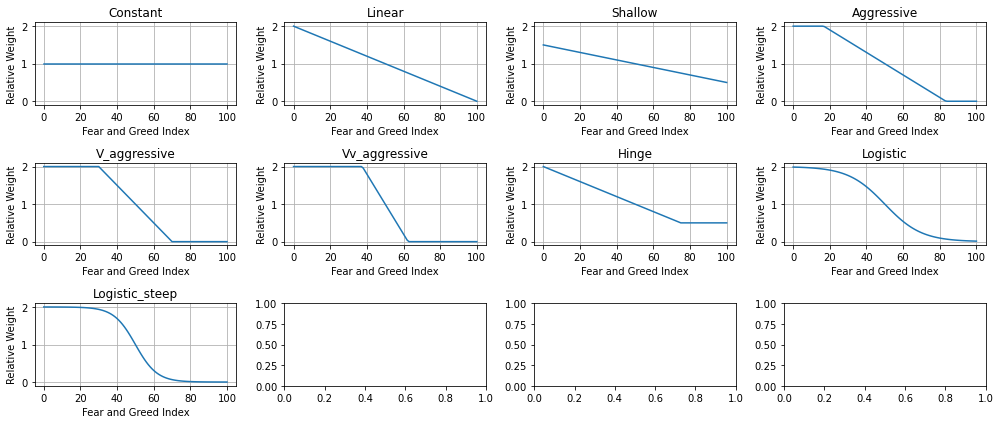

In [30]:
new_weight_df = apply_weighting(weight_df, weight_dict, 'Fear and Greed Index')

In [31]:
for weight_name, weight_func in weight_dict.items():
    fg_w_df['fg_%s' % (weight_name)] =  fg_w_df.fear_greed.apply(weight_func)

## Testing and plotting

In [32]:
"""
Paramters for the DCA:
- amount:     Total amount to invest (cannot be exceeded but does not have to be spent)
- freq_d:     Time between buys (days e.g 7 would be 1 buy a week) 
- dollar:     $ Value to buy (when weigting = 1)
- since:      Date of first DCA investment
"""
params = {
          'amount':   10000,
          'freq_d':   7,
          'dollar':   100,
          'since': datetime.now()-timedelta(days=365*3.3)  
         }

In [33]:
"""
Runs dcas and returns a DCA df with the performance of the different strategies
"""
def run_dcas(fg_w_df, params, weight_dict, ticker='btc', plot=False, print_dca=True):

    print('%s Since: %s\n' % (ticker.upper(), params['since'].strftime('%d %b %Y')))
    this_df = fg_w_df[fg_w_df.ticker==ticker]

    my_dca = DCA(params['amount'], this_df, since=params['since'])

    backtest_df = pd.DataFrame()

    # Calculating the bought volume for the each
    for weight_name in weight_dict:
        vols, spent, prices, dates, ret_df = my_dca.get_average(params['dollar'], params['freq_d'], ticker, weighting='fg_%s'%(weight_name))
        ret_df['portfolio_value'] = ret_df.crypto_tot * ret_df.price + ret_df.dollar_left
        ret_df['weighting'] = weight_name
        backtest_df = backtest_df.append(ret_df)

        # Optional plotting
        if plot:
            fig, ax = plt.subplots(1,2,figsize=(15,3))

            ax1 = ax[0]
            ax2 = ax[0].twinx()
            ax3 = ax[1]
            ax4 = ax[1].twinx()
            ax5 = ax[1].twinx()

            ax1.plot(dates,fg_w_df[fg_w_df.ticker==ticker].loc[dates].close, color='orange',label=ticker)
            ax2.plot(dates, fg_w_df[fg_w_df.ticker==ticker].loc[dates].fear_greed, color='r', label='Fear and Greed')

            ax3.plot(dates, list(accumulate(vols)), color='b', label=ticker+' accumulated')
        #     ax5.plot(dates, list(accumulate(vols), color='r', label='Portfolio Value ($)')
            ax4.plot(dates, vols, color='g', label='Daily Vol')

            ax1.set_yscale('log')
            
            ax1.legend(loc='lower right')
            ax2.legend(loc='upper left')
            ax3.legend(loc='upper right')
            ax4.legend(loc='lower left')

            plt.show()
            
        if print_dca:
            print('%s DCA:    %.6f %s    $%.2f Leftover\n' % (weight_name, sum(vols), ticker.upper(), params['amount']-spent))
        
    return backtest_df


"""
Plots dca methods with different weighting and stategies over time
Gives the amount in $ of the crypto you would own
"""
def plot_dcas(backtest_df, title_str='DCA strategies over time'):
    plt.figure(figsize=(13,7))
    
    total_weights = []
    
    for weight_name in backtest_df.weighting.unique():

        sub_df = backtest_df[backtest_df.weighting==weight_name]
        
        finish_df = sub_df[sub_df.dollar_left <= 0]
        if not finish_df.empty:
            finish_row = finish_df.iloc[0]
            plt.scatter([finish_row.name],[finish_row.portfolio_value], marker='^', s=[100], zorder=10)
        else:
            finish_row = sub_df.iloc[-1]
        
        label='$%.0f ~ %.0f%% invested - %s' % (sub_df.iloc[-1].portfolio_value, 100*(
            1-sub_df.iloc[-1].dollar_left/(sub_df.iloc[-1].dollar_left+sub_df.iloc[-1].dollar_spend_tot)), weight_name)
        line, = plt.plot(sub_df.index,sub_df.portfolio_value,label=label,linewidth=1)
        total_weights.append([sub_df.iloc[-1].portfolio_value, line, weight_name])
        
    plt.title(title_str)
    plt.yscale('log')
    plt.grid()
    labels = [i[1] for i in sorted(total_weights, key=lambda x : x[0], reverse=True)]

    plt.legend(handles=labels)
    plt.show()

In [34]:
# Plot to show portfolio value over time with different fear and greed weighting schemes

ssince_dates = pd.date_range(start=datetime.now()-timedelta(days=365*3.3), end=datetime.now()-timedelta(weeks=20), periods=5)
for since in since_dates:
    params['since'] = since
    backtest_df = run_dcas(fg_w_df, params, weight_dict, plot=False, print_dca=False)
    title_str = 'Buy %d USD every %dD up to %d USD Since: %s ' % (params['dollar'],params['freq_d'], params['amount'],
                                                                            params['since'].strftime('%d %b %Y'))
    plot_dcas(backtest_df, title_str)

NameError: name 'since_dates' is not defined

In [ ]:
ticker = 'btc'

print(ticker.upper(),'\n')
this_df = fg_w_df[fg_w_df.ticker==ticker]

my_dca = DCA(params['amount'], this_df)

vols, spent, prices, dates = my_dca.get_average(params['dollar'], params['freq_d'], ticker)
print('Regular DCA:    %.6f %s   $%.2f Leftover\n' % (sum(vols), ticker.upper(), params['amount']-spent))

# Calculating the bought volume for the each
for weight_name in weight_dict:
    vols, spent, prices, dates = my_dca.get_average(params['dollar'], params['freq_d'], ticker, weighting='fg_%s'%(weight_name))
    
    fig, ax1 = plt.subplots(figsize=(13,5))

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()

    ax1.plot(dates,fg_w_df[fg_w_df.ticker==ticker].loc[dates].close, color='orange',label=ticker)
    ax2.plot(dates, list(accumulate(vols)), color='b', label=ticker+' accumulated')
    ax3.plot(dates, fg_w_df[fg_w_df.ticker==ticker].loc[dates].fear_greed, color='r', label='Fear and Greed')
    ax4.plot(dates, vols, color='g', label='Daily Vol')
    
    ax1.set_yscale('log')
    ax1.legend(loc='lower right')
    ax2.legend(loc='upper left')
    ax3.legend(loc='upper right')
    ax4.legend(loc='lower left')
    plt.grid()
    plt.show()
    
    print('%s DCA:    %.6f %s    $%.2f Leftover\n' % (weight_name, sum(vols), ticker.upper(), params['amount']-spent))

print('\n\n')

## Exponentially decreasing with price

In [ ]:
exp_df = fg_df.copy()

In [ ]:
max_price = 30000
min_price = 1000
aggression = 1
expstr = 'exp_'

In [ ]:
exp_dict = {}
line = np.linspace(min_price, max_price, 101)

exp_weight_df = pd.DataFrame(line, columns=['line'])
exp_weight_df.sort_values('line',ascending=False).reset_index(inplace=True)
exp_weight_df.index = exp_weight_df.line
exp_weight_df

In [ ]:
weight_name = 'normal'
# exp_dict[weight_name] = agg1 = lambda x : np.exp(-x/(max_price-min_price)*3+1.2)
exp_dict[weight_name] = agg1 = lambda x : np.exp(-3*x/(max_price-min_price))+0.5
apply_weighting(exp_weight_df, weight_name, agg1, 'Bitcoin Price', replace=True)

In [ ]:
for weight_name, weight_func in exp_dict.items():
    exp_df['%s%s' % (expstr, weight_name)] =  exp_df.close.apply(weight_func)

In [ ]:
params = {'amount':   90000,
          'freq_d':   1,
          'dollar':   100
         }

df = exp_df


for ticker in all_tickers:
    if ticker == 'btc':

        print(ticker.upper(),'\n')
        this_df = df[df.ticker==ticker]

        my_dca = DCA(params['amount'], this_df)


        vols, spent, prices = my_dca.get_average(params['dollar'], params['freq_d'], ticker, )
        print('Regular DCA:    %.6f %s   $%.2f Leftover\n' % (sum(vols), ticker.upper(), params['amount'] - spent))

        # Calculating the bought volume for the each
        for weight_name in exp_dict:
            vols, spent, prices = my_dca.get_average(params['dollar'], params['freq_d'], ticker, weighting='%s%s'%(expstr, weight_name))
            print('%s DCA:    %.6f %s    $%.2f Leftover\n' % (weight_name, sum(vols), ticker.upper(), params['amount'] - spent))

        print('\n\n')